In [96]:
import xgboost as xgb
import pandas as pd
import numpy as np

from src.features import build_features as f
from importlib import reload
reload(f)

vladdy = 665489
soto = 665742
schneider = 676914
batter = soto

X_train, y_train, X_test, y_test, encoders = f.get_pitch_outcome_dataset_xgb(batter, split=True)

In [97]:
label_mappings = encoders['pitch_outcome'].classes_
for idx, label in enumerate(label_mappings):
    print(idx, label)

0 ball
1 foul
2 hit_by_pitch
3 hit_into_play
4 strike


In [98]:
params = {
    'objective' : 'multi:softprob',
    'eval_metric': 'mlogloss',      
    'learning_rate': 0.01,
    'max_depth': 2, 
    'n_estimators': 500 
}
clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

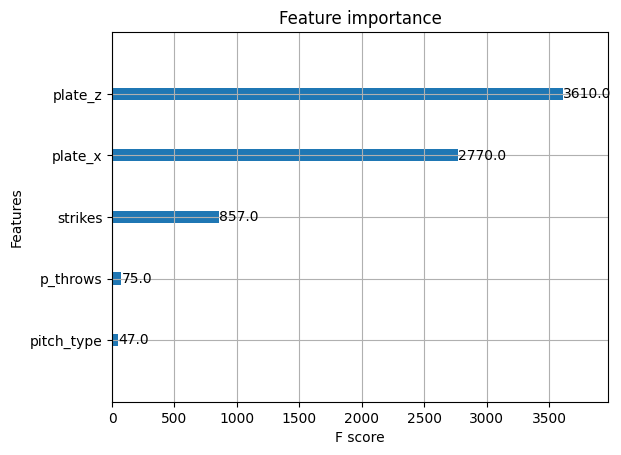

In [99]:
xgb.plot_importance(clf)

In [100]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_train, clf.predict(X_train)))
print("Accuracy:", accuracy_score(y_test, clf.predict(X_test)))

Accuracy: 0.6538227892042003
Accuracy: 0.6506118198385837


In [101]:
def compute_xgboost_loglik(y_pred_proba, y_test, target_col):
    loglik = 0
    for idx, target in enumerate(y_test[target_col]):
        loglik += np.log(y_pred_proba[idx, target])
    return loglik

def compute_cat_loglik(X_train, y_train, y_test, target_col):

    df = pd.concat([X_train, y_train], axis=1)
    
    pitch_cat_prob = (df[target_col].value_counts() / len(df)) #.reset_index()
    #pitch_cat_prob[f'{target_col}_encoded'] = encoders[target_col].transform(pitch_cat_prob[target_col])
    #pitch_cat_prob.set_index(f'{target_col}_encoded')
    
    loglik = 0
    for target in y_test[target_col]:
        loglik += np.log(pitch_cat_prob.loc[target])
    return loglik

target_col = 'pitch_outcome'
xgb_loglik = compute_xgboost_loglik(clf.predict_proba(X_test), y_test, target_col)
cat_loglik = compute_cat_loglik(X_train, y_train, y_test, target_col)

print(f'XGB: {xgb_loglik:.2f}, CAT: {cat_loglik:.2f}')

XGB: -3426.61, CAT: -4918.92


In [29]:
confusion_matrix(y_test, clf.predict(X_test))

array([[82,  1,  0,  0,  8],
       [ 6,  2,  0,  1, 30],
       [ 0,  1,  0,  0,  0],
       [ 1,  0,  0,  2, 25],
       [ 8,  1,  0,  0, 61]])

In [ ]:
import shap
import xgboost as xgb

# Assuming you have already trained an XGBoost classification model
#model = xgb.XGBClassifier()
#model.fit(X_train, y_train)

# Create an explainer object
explainer = shap.Explainer(clf)

# Calculate SHAP values for a subset of the data (e.g., validation set)
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
#shap.summary_plot(shap_values, X_train, plot_type='dot', show=False)
background = shap.maskers.Independent(X_test, max_samples=100)
explainer = shap.Explainer(clf, background)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [122]:
# Define feature names
feature_names = X_train.columns.tolist()  # Assuming X_train is a DataFrame

# Create an explainer object with background data
background = shap.maskers.Independent(X_test, max_samples=100)
explainer = shap.Explainer(clf, background, feature_names=feature_names)

# Calculate SHAP values for test data
shap_values = explainer(X_test)

# Visualize variable importance using a SHAP bar plot

100%|===================| 19194/19205 [03:13<00:00]        

IndexError: list index out of range

In [123]:
shap.plots.bar(shap_values, feature_names=feature_names)

TypeError: bar() got an unexpected keyword argument 'feature_names'

In [124]:
feature_names = X_train.columns.tolist()  # Assuming X_train is a DataFrame
print(feature_names)
# Create an explainer object with background data
background = shap.maskers.Independent(X_test, max_samples=100)
explainer = shap.Explainer(clf, X_train, feature_names=feature_names)

# Calculate SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Visualize variable importance using a SHAP bar plot
shap.plots.bar(shap_values)

['pitch_type', 'p_throws', 'strikes', 'balls', 'plate_x', 'plate_z']


100%|===================| 19150/19205 [03:15<00:00]        

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!